<a href="https://colab.research.google.com/github/DarkMirr1227/IRSChannelEstimate_CNN/blob/main/IRS_dataCNN_0524.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from cmath import sqrt
from cmath import exp
from ctypes import sizeof
from random import random 
import os
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d #3d 그래프 만들 때 사용
global wavelength,antenaGain,elementSizeM,elementSizeN,expone
mNum=7
nNum=7
#position값은 3차원 array라고 가정, 입사각인 theta도 구할 수 있게 프로그래밍해야함 
def positionSet(BSpos,IRSpos,UEpos):
    ''' bs,irs,ue의 3차원 포지션값을 이용하여 거리를 구하는 함수.
    
        args:
            BSpos: basestation의 (x,y,z) 값
            IRSpos: IRS의 정중앙(x,y,z) 값
            UEpos: UE의 (x,y,z) 값
        
        returns:
            dict('D_mn':bs과irs의 거리, 'd_mn':irs와ue의 거리, 'd_bu':bs와ue의 직선거리)
    '''
    D_mn = 0.
    d_mn = 0.
    d_bu = 0.
    #BS-IRS distance(D_mn) , IRS-UE distane(d_mn) , BS-UE direct distance(d_bu)
    for i in range(0,3,1):
        D_mn += (BSpos[i]-IRSpos[i])**2 
        d_mn += (IRSpos[i]-UEpos[i])**2
        d_bu += (BSpos[i]-UEpos[i])**2
    D_mn = math.sqrt(D_mn)
    d_mn = math.sqrt(d_mn)
    d_bu = math.sqrt(d_bu)
    return {'D_mn':D_mn,'d_mn':d_mn,'d_bu':d_bu}

def calcTheta(BSpos,IRSpos,UEpos):
    '''bs,irs,ue의 3차원 포지션값을 이용하여 입사각을 구하는 함수.

        args:
            BSpos: basestation의 (x,y,z) 값
            IRSpos: IRS의 정중앙(x,y,z) 값
            UEpos: UE의 (x,y,z) 값

        return:
            입사각(theta) : 세점 사이의 각도의 절반        
    '''
    v1 = BSpos-IRSpos
    v2 = UEpos-IRSpos
    return np.inner(v1,v2)/(np.linalg.norm(v1) *np.linalg.norm(v2)*2)

def initValue(_wavelength,_antenaGain=1,_elementSizeM=0.04,_elementSizeN=0.04,_expone=2):
    ''' 수식계산을 위한 초기값(상수)을 설정하는 함수.
        
    입력값을 글로벌변수에 대입한다.
    
        args:
            _wavelength: 파장길이( m단위)
            _antenaGain: 안테나 이득(default=1)
            _elementSizeM: IRS element의 세로 길이
            _elementSizeN: IRS element의 가로 길이
            _expone: 신호를 구하는 수식에서의 alpha값 (default=2)
        
        return:
            없음
    '''
    global wavelength,antenaGain,elementSizeM,elementSizeN,expone
    wavelength = _wavelength
    antenaGain = _antenaGain
    elementSizeM = _elementSizeM
    elementSizeN = _elementSizeM
    expone = _expone

def calc(_theta,_D_mn,_d_mn,_d_bu):
    '''변수값을 입력받아 r_mn*h_mn을 구하는 함수

        args:
            _theta: 입사각
            _D_mn: BS와 IRS의 거리
            _d_mn: IRS와 UE의 거리
            _d_bu: BS와 UE의 직선거리
        
        return:
            r_mn*h_mn
    '''
    global wavelength,antenaGain,elementSizeM,elementSizeN,expone
    result1 = math.cos(_theta) * wavelength *sqrt(antenaGain*elementSizeM*elementSizeN) / ((4*math.pi)**(3/2)*sqrt(_D_mn*_d_mn)**expone)
    temp = (math.pi * _d_bu / wavelength)%(2*math.pi)
    result2 = exp(-2j * temp)
    return (result1*result2)

def setElementPosXZ(IRSpos,mNum,nNum,delta=0):
    '''IRS 각각의 element position값을 구하는 함수. 여기서 IRS의 element의 Y값은 모두 동일한 경우에만 사용가능.

    즉, 변하는값이 "x","z"일때만 해당 함수를 사용할 수 있음.

        args:
            IRSpos: IRS의 정중앙(x,y,z) 값
            mNum: IRS의 총 element 가로 갯수
            nNum: IRS의 총 element 세로 갯수
            delta: element 사이의 간격/distance (default =0)
        
        return:
            elementPos: 각 element(m,n)에 따른 position값
    '''
    elementPos = np.zeros((mNum,nNum,3))
    for m in range(0,mNum,1):
        for n in range(0,nNum,1):
            elementPos[m][n][0] = IRSpos[0] -(mNum+1)/2*(delta+elementSizeN) + (n+1)*(delta+elementSizeN)
            elementPos[m][n][1] = IRSpos[1]
            elementPos[m][n][2] = IRSpos[2] +(nNum+1)/2*(delta+elementSizeM) - (m+1)*(delta+elementSizeM)

    return elementPos

def allElementCalc(BSpos,IRSpos,UEpos,mNum,nNum):
    '''각 IRS element 수만큼 거리,theta값을 구하여 r_mn*h_mn을 구하는 함수
    
        args:
            BSpos: basestation의 (x,y,z) 값
            IRSpos: IRS의 정중앙(x,y,z) 값
            UEpos: UE의 (x,y,z) 값
            mNum: IRS의 총 element 가로 갯수
            nNum: IRS의 총 element 세로 갯수

        return:
            elementResult: 각 element(m,n)의 r_mn*h_mn 값            
            
    '''
    elementPos = setElementPosXZ(IRSpos,mNum,nNum)
    elementResult = np.zeros((mNum*nNum),dtype=np.complex64)
    for m in range(0,mNum,1):
        for n in range(0,nNum,1):
            dicDist = positionSet(BSpos,elementPos[m][n],UEpos)
            theta = calcTheta(BSpos,elementPos[m][n],UEpos)
            #elementResult[m][n] = calc(theta,dicDist['D_mn'],dicDist['d_mn'],dicDist['d_bu'])
            elementResult[m*nNum+n] = calc(theta,dicDist['D_mn'],dicDist['d_mn'],dicDist['d_bu']).real

    return elementResult

In [ ]:
initValue(0.01)
Baseposition = np.array([0,50,35])
IRSposition = np.array([75,100,2])
UEposition = np.array([50+random()*50,random()*50,1+random()])
result = allElementCalc(Baseposition,IRSposition,UEposition,mNum,nNum)
# dicDist = positionSet(Baseposition,IRSposition,UEposition)
# theta = calcTheta(Baseposition,IRSposition,UEposition)
# temp = calc(theta,dicDist['D_mn'],dicDist['d_mn'],dicDist['d_bu'])
"""
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X = np.linspace(0,mNum-1,mNum,dtype=np.int64)
Y = np.linspace(0,nNum-1,nNum,dtype=np.int64)
X,Y = np.meshgrid(X,Y)
result = np.reshape(result,(mNum,nNum))
ax.plot_surface(X,Y,result)
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111,projection='3d')\nX = np.linspace(0,mNum-1,mNum,dtype=np.int64)\nY = np.linspace(0,nNum-1,nNum,dtype=np.int64)\nX,Y = np.meshgrid(X,Y)\nresult = np.reshape(result,(mNum,nNum))\nax.plot_surface(X,Y,result)\nplt.show()\n"

In [ ]:
#datalist에 data 쌓기
datalist = []
for count in range(0,10000,1):
    UEposition = np.array([50+random()*50,random()*50,1.5+random()-0.5])
    result = allElementCalc(Baseposition,IRSposition,UEposition,mNum,nNum)
    datalist.append(result)

list_len = len(datalist)
print(list_len)


10000


In [ ]:
print(datalist[0:10])

[array([1.3187234e-09+0.j, 1.3183431e-09+0.j, 1.3179626e-09+0.j,
       1.3175817e-09+0.j, 1.3172006e-09+0.j, 1.3168191e-09+0.j,
       1.3164372e-09+0.j, 1.3185222e-09+0.j, 1.3181422e-09+0.j,
       1.3177618e-09+0.j, 1.3173811e-09+0.j, 1.3170001e-09+0.j,
       1.3166188e-09+0.j, 1.3162371e-09+0.j, 1.3183203e-09+0.j,
       1.3179405e-09+0.j, 1.3175603e-09+0.j, 1.3171798e-09+0.j,
       1.3167990e-09+0.j, 1.3164179e-09+0.j, 1.3160364e-09+0.j,
       1.3181179e-09+0.j, 1.3177383e-09+0.j, 1.3173582e-09+0.j,
       1.3169780e-09+0.j, 1.3165973e-09+0.j, 1.3162164e-09+0.j,
       1.3158350e-09+0.j, 1.3179149e-09+0.j, 1.3175354e-09+0.j,
       1.3171556e-09+0.j, 1.3167755e-09+0.j, 1.3163950e-09+0.j,
       1.3160142e-09+0.j, 1.3156330e-09+0.j, 1.3177112e-09+0.j,
       1.3173319e-09+0.j, 1.3169522e-09+0.j, 1.3165723e-09+0.j,
       1.3161919e-09+0.j, 1.3158113e-09+0.j, 1.3154304e-09+0.j,
       1.3175069e-09+0.j, 1.3171277e-09+0.j, 1.3167483e-09+0.j,
       1.3163685e-09+0.j, 1.3159883e-09

In [ ]:
#CNN
# https://colab.research.google.com/drive/1pQrVoegUi7OqgJbXqa-dSGo7NyS_4j8m#scrollTo=9BI_Jc-8DcdW
datalist = np.array(datalist)
datalist = (datalist-datalist.min())/(datalist.max()-datalist.min()) #0~1값 설정
train = np.array(datalist[0:int(list_len*0.8)])
test = np.array(datalist[int(list_len*0.8):])

#일단은 48개 주면 나머지 1개 예측하는 걸로 뼈대 제작
x_train=train.copy()
y_train =[]
for item in x_train:
  y_train.append(item[8])
  for i in range(1,49,7):
    item[i] =0
  for i in range(3,49,7):
    item[i] =0
  for i in range(5,49,7):
    item[i] =0    
  for i in range(7,49,14):
    item[i] =0
  for i in range(9,49,14):
    item[i] =0
  for i in range(11,49,14):
    item[i] =0
  for i in range(13,49,14):
    item[i] =0
x_train = np.reshape(x_train,(-1,7,7))
y_train = np.array(y_train) #list를 np.array로 변환
y_test = []
x_test=test[0:]
for item in x_test:
  y_test.append(item[8])
  for i in range(1,49,7):
    item[i] =0
  for i in range(3,49,7):
    item[i] =0
  for i in range(5,49,7):
    item[i] =0    
  for i in range(7,49,14):
    item[i] =0
  for i in range(9,49,14):
    item[i] =0
  for i in range(11,49,14):
    item[i] =0
  for i in range(13,49,14):
    item[i] =0
x_test = np.reshape(x_test,(-1,7,7))
y_test = np.array(y_test)


In [ ]:
print(x_train[0])

[[0.86711746+0.j 0.        +0.j 0.8669044 +0.j 0.        +0.j
  0.86669093+0.j 0.        +0.j 0.86647713+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j]
 [0.8670046 +0.j 0.        +0.j 0.86679167+0.j 0.        +0.j
  0.8665784 +0.j 0.        +0.j 0.86636484+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j]
 [0.866891  +0.j 0.        +0.j 0.8666783 +0.j 0.        +0.j
  0.8664653 +0.j 0.        +0.j 0.8662519 +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j]
 [0.8667767 +0.j 0.        +0.j 0.8665642 +0.j 0.        +0.j
  0.8663514 +0.j 0.        +0.j 0.8661382 +0.j]]


In [ ]:

"""
x_test = x_test / 255
x_train = x_train / 255
x_train = x_train.reshape(x_train.shape[0], mNum, nNum, 1)
x_test = x_test.reshape(x_test.shape[0], mNum, nNum, 1)

# one hot encode y data
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
"""
# hyper parameters
learning_rate = 0.0001
training_epochs = 150
batch_size = 100
"""
tf.model = tf.keras.Sequential()

tf.model.add(tf.keras.layers.Dense(units=1, input_dim=36))  # input_dim=3 gives multi-variable regression
tf.model.add(tf.keras.layers.Activation('relu'))  # Activation의 default 가 'linear'라서 없어도 되긴함. 
# advanced reading https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

tf.model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-3))
tf.model.summary()
"""

 #CNN layer
# (N-F)/stride +1 -> output
tf.model = tf.keras.Sequential()
# L1
# Conv2D(filters = 필터갯수 , kernel_size = 커널 사이즈, input_shape= , padding ='same')
# Maxpooling(pool_size = , strides = ) ->다운 스케일링 같은 거
tf.model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), input_shape=(7, 7, 1), activation='leaky_relu', padding='same'))
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # size 2x2, stride = 2

# L2
#tf.model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 2), activation='leaky_relu'))
#tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# L3 fully connected               
tf.model.add(tf.keras.layers.Flatten())
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal',bias_initializer='zeros', activation='relu'))
tf.model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['mape'])
tf.model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 7, 7, 1)           10        
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 3, 3, 1)          0         
 g2D)                                                            
                                                                 
 flatten_72 (Flatten)        (None, 9)                 0         
                                                                 
 dense_72 (Dense)            (None, 1)                 10        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#tf.model.fit(x_train, y_train,epochs=1000)
history = tf.model.fit(x_train, y_train, batch_size=batch_size, epochs=150,validation_data = (x_test, y_test))

Epoch 1/150
80/80 [==============================] - 1s 5ms/step - loss: 0.1656 - mape: 72.7122 - val_loss: 0.1534 - val_mape: 68.4680
Epoch 2/150
80/80 [==============================] - 0s 3ms/step - loss: 0.1408 - mape: 65.9799 - val_loss: 0.1292 - val_mape: 60.8627
Epoch 3/150
80/80 [==============================] - 0s 3ms/step - loss: 0.1174 - mape: 59.4556 - val_loss: 0.1066 - val_mape: 53.4451
Epoch 4/150
80/80 [==============================] - 0s 3ms/step - loss: 0.0959 - mape: 54.1384 - val_loss: 0.0861 - val_mape: 46.4990
Epoch 5/150
80/80 [==============================] - 0s 3ms/step - loss: 0.0766 - mape: 47.9349 - val_loss: 0.0681 - val_mape: 40.3805
Epoch 6/150
80/80 [==============================] - 0s 3ms/step - loss: 0.0600 - mape: 43.6852 - val_loss: 0.0527 - val_mape: 35.2117
Epoch 7/150
80/80 [==============================] - 0s 3ms/step - loss: 0.0460 - mape: 39.9383 - val_loss: 0.0400 - val_mape: 31.1360
Epoch 8/150
80/80 [==============================] - 0s

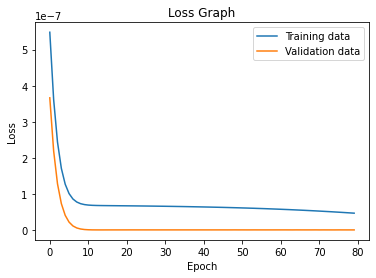

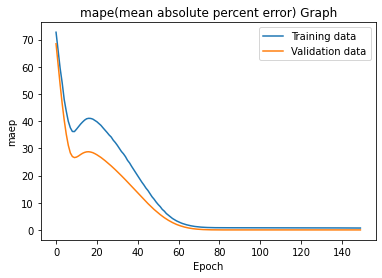

In [ ]:
#그래프 출력
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'][70:])           # loss
plt.plot(history.history['val_loss'][70:])       # validation
plt.legend(['Training data', 'Validation data'], loc=0)
plt.show()

plt.title('mape(mean absolute percent error) Graph')
plt.ylabel('maep')
plt.xlabel('Epoch')
plt.plot(history.history['mape'])           # mape
plt.plot(history.history['val_mape'])       # validation
plt.legend(['Training data', 'Validation data'], loc=0)
plt.show()

In [ ]:
#load_status =tf.model.load_weights("ckpt") # "ckpt로 저장된 값 불러오기"


y_predicted =tf.model.predict(x_test)
failcount = 0
successcount = 0

for i in range(0,len(y_test)):
  print("\n실제값[",i,"] :",y_test[i])
  print("예측값[",i,"] :",y_predicted[i])
  print("이웃값[",i,"] :",x_test[i][0][0])
  #print("이웃값[",i,"] :",x_test[i][28])
  if abs(y_test[i].real-y_predicted[i].real) < abs(y_test[i].real-x_test[i][0][0].real):
    successcount +=1
print("정확도 :",successcount/len(y_test))

evaluation = tf.model.evaluate(x_test,y_test)
print('loss, mape : ',evaluation)

#tf.model.save("my_model")
#tf.model.save_weights("ckpt")

#load_status =tf.model.load_weights("ckpt")
"""
# predict 10 random hand-writing data
y_predicted = tf.model.predict(x_test)
for x in range(0, 10):
    random_index = random.randint(0, x_test.shape[0]-1)
    print("index: ", random_index,
          "actual y: ", np.argmax(y_test[random_index]),
          "predicted y: ", np.argmax(y_predicted[random_index]))

evaluation = tf.model.evaluate(x_test, y_test)
print('loss: ', evaluation[0])
print('accuracy', evaluation[1])
"""

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
이웃값[ 750 ] : (0.21421416+0j)

실제값[ 751 ] : (0.2474061+0j)
예측값[ 751 ] : [0.24742854]
이웃값[ 751 ] : (0.24732338+0j)

실제값[ 752 ] : (0.22475019+0j)
예측값[ 752 ] : [0.22475043]
이웃값[ 752 ] : (0.22462012+0j)

실제값[ 753 ] : (0.54506886+0j)
예측값[ 753 ] : [0.54507554]
이웃값[ 753 ] : (0.5450994+0j)

실제값[ 754 ] : (0.687887+0j)
예측값[ 754 ] : [0.68790394]
이웃값[ 754 ] : (0.6880015+0j)

실제값[ 755 ] : (0.35270822+0j)
예측값[ 755 ] : [0.35269612]
이웃값[ 755 ] : (0.3526171+0j)

실제값[ 756 ] : (0.69794387+0j)
예측값[ 756 ] : [0.69797194]
이웃값[ 756 ] : (0.6980837+0j)

실제값[ 757 ] : (0.1640112+0j)
예측값[ 757 ] : [0.16396411]
이웃값[ 757 ] : (0.16377436+0j)

실제값[ 758 ] : (0.3455168+0j)
예측값[ 758 ] : [0.34550652]
이웃값[ 758 ] : (0.34542534+0j)

실제값[ 759 ] : (0.3176975+0j)
예측값[ 759 ] : [0.31769222]
이웃값[ 759 ] : (0.3176014+0j)

실제값[ 760 ] : (0.6961857+0j)
예측값[ 760 ] : [0.6962088]
이웃값[ 760 ] : (0.6963129+0j)

실제값[ 761 ] : (0.5509976+0j)
예측값[ 761 ] : [0.55100363]
이웃값[ 761 ] : (0.5510298+0j)

실제값[ 762 ] : (0

'\n# predict 10 random hand-writing data\ny_predicted = tf.model.predict(x_test)\nfor x in range(0, 10):\n    random_index = random.randint(0, x_test.shape[0]-1)\n    print("index: ", random_index,\n          "actual y: ", np.argmax(y_test[random_index]),\n          "predicted y: ", np.argmax(y_predicted[random_index]))\n\nevaluation = tf.model.evaluate(x_test, y_test)\nprint(\'loss: \', evaluation[0])\nprint(\'accuracy\', evaluation[1])\n'

35개중 1개 맞추기 기준.
모든값 0으로 예측할 시 
loss= 0.303

1. 	리니어
	데이터 500개 , train/test 비율 8:2, lr=0.001
	epoch 1000번, => loss = 1.2530e-08
	epoch 2000번, => loss = 7.8141e-09

2.	합성곱
	데이터 500개, train/test 비율 8:2, lr=0.001 
	epoch 1000번, => loss = 3.0735e-08

3.	합성곱
	데이터 500개, train/test 비율 8:2, lr=0.001 / glrot_uniform
	epoch 1000번, => loss = 2.5336e-08	

4.	합성곱
	데이터 500개, train/test 비율 8:2, lr=0.001 / glrot_uniform
	epoch 2000번, => loss = 2.5541e-07  / 오히려 정확도 낮아짐... 	


18개중 1개 맞추기 기준

1.	리니어
	데이터 500개, train/test 비율 8:2, lr=0.001
	epoch 1000번, => loss = 1.9166e-09

2.	합성곱
	데이터 500개, train/test 비율 8:2, lr=0.001 / glrot_uniform
	epoch 1000번, => loss = 2.0977e-08	

9개 중에 1개 맞추기 기준
1.	합성곱
	데이터 500개, train/test 비율 8:2, lr=0.001 / glrot_uniform
	epoch 1000번, => loss = 1.3817e-07

노이즈(-96dbm)추가 후 9개중 1개 맞추기 기준
1.	합성곱
	데이터 500개, train/test 비율 8:2. lr=0.001
	epoch 1000번 =>loss = 	0.0294    0.0239    0.0288 
2.	리니어
	데이터 500개, train/test 비율 8:2. lr=0.001
	epoch 1000번 =>loss = 	0.0260    0.0300    0.0319 
